<a href="https://colab.research.google.com/github/awosoga/ssc2023/blob/main/Unfinished/SPATIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

class CustomLoss1(nn.Module):
    """
    A class which defines a custom loss function
    """
    def __init__(self):
        super().__init__()
        self.l1loss = nn.L1Loss()

    def forward(self, output, labels):
        """
        The loss function implemented is e^(3*abs(y_pred - y_true))
        """
        x = self.l1loss(output, labels)
        loss = torch.mean(torch.expm1(torch.mul(x, 3)))
        # print("X: ",x, " Loss: ", loss)
        return loss


class CustomLoss2(nn.Module):
    """
    A class which defines a custom loss function
    """
    def __init__(self):
        super().__init__()
        self.l1loss = nn.L1Loss()

    def forward(self, output, labels):
        """
        The loss function implemented is e^(1.5*(y_pred - y_true)^2)
        """
        x = self.l1loss(output, labels)
        loss = torch.mean(torch.expm1(torch.mul(x ** 2, 1.5)))
        # print("X: ",x, " Loss: ", loss)
        return loss


class CustomLoss3(nn.Module):
    def __init__(self):
        super().__init__()
        self.l2loss = nn.MSELoss()

    def forward(self, output, labels):
        """
        The loss function implemented is 3*(y_pred - y_true)^2
        """
        x = self.l2loss(output, labels)
        loss = torch.mul(x, 3)
        # print("X: ",x, " Loss: ", loss)
        return loss

In [ ]:
from itertools import product
parameters = dict(  batchsize = [64],
                        nhidden_encoder = [64],
                        nhidden_decoder = [64],
                        ntimestep = [20],
                        lr = [0.001],
                        epochs = [110],
                        loss_func = [CustomLoss1, CustomLoss2, CustomLoss3],
                        diff = [True]
                    )

param_values = [v for v in parameters.values()]
print("Number of runs: ", len(list(product(*param_values))))


Number of runs:  3


## SPATIAL model for ADCP data

In [ ]:
# Modified SP_Learner
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers import  Masking
from scipy.interpolate import UnivariateSpline,CubicSpline
output = './figs'
#---------------------------data analysis-------------------------------------
# flattern the batch time series data into a m by n matrix
# m= p.shape[1]: number of sensors, n=p.shape[0]*p.shape[2]: time steps
def flattern(p):
    pred_y_matrix = [[]for _ in range(len(p[0])) ]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


#interpolate the missing values with mask value
# def interpolate(data, mask):
#     temp = [list(dd) for dd in data]
#     d = []
#     for i in range(len(temp)):
#         for j in range(len(temp[i])):
#             if temp[i][j] == mask: temp[i][j]= float("NaN")
#         df = pd.Series(temp[i]).interpolate(method='linear')
#         d.append(df.tolist())
#     return d

#Continous data split for masked and unmasked data:
def split_train(Int_dat, Norm_dat,T1,T2,T3,Stride, start, end,data_name):
    length  = len(Int_dat[0])
    s = int(length*start)
    e = int(length*end)
    Train = [ N[:s] + N[e:] for N in Norm_dat ]
    Test  = [ M[s:e] for M in Int_dat ]
    print('Training Data Length: ', len(Train),'X',len(Train[0]))
    print('Test Data Length: ', len(Test), 'X',len(Test[0]))
    print('Testing percentage: ',len(Test[0])/(len(Test[0])+len(Train[0]))*100,'%' )
    print('Total data size: ', len(Int_dat), 'X', len(Int_dat[0]))
    np.savetxt(data_name + '_train.txt', np.exp(np.array(Train)))
    np.savetxt(data_name + '_test.txt', np.exp(np.array(Test)))
    train_x, train_y = data_split(Train, T1, T2, T3,Stride)
    test_x, test_y = data_split(Test, T1, T2, T3,Stride)
    return train_x, train_y, test_x, test_y

# split data for Multivairate time series (matrix of sensors)
# the data is fed to Bidirectional LSTM model
def data_split(dat, train_hour, test_hour, predict_position,  stride):
    #train_hour: training data length
    #test_hour: testing data length
    #predict_position: gap between train_hour and test_hour
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    while i + period <= len(dat[0]):
        x_temp = []
        y_temp = []
        for j in range(len(dat)):
            x_temp.append(dat[j][i:i + train_hour])
            y_temp.append(dat[j][i+ train_hour+ predict_position:i+ train_hour+ predict_position +test_hour])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)

# Data normalization:
# using log function and skip the masked data with -1
# 0 values are replaced by 1e-5 in order to avoid nan value in log
def data_normalize(Dat):
    new_dat  = []
    for d in Dat:
        min, max = np.min(sorted(list(set(d)))[1]), np.max(d)
        a = max - min
        temp = []
        for val in d:
            #if val == -1: temp.append(val)
            #else:
          #norm =np.log(val) if val!=0 else 1e-5
          #temp.append(norm ) 
          temp.append((val - min)/a ) #homebrew minmax scaler
        new_dat.append(temp)
    return new_dat

#---------------------------MAE STD-------------------------------------
def log_mae(py,ty, t,plot_name):
    print('predict data size: ',len(py),len(py[0]))
    print('exact data size: ', len(ty), len(ty[0]))
    mae_lis = []
    std = []
    for i in range(len(py)):
        mae = np.exp(np.array(py[i])) - np.exp(np.array(ty[i]))
        #print('Predicted Data Point size for sensor '+str(i+1)+' ', len(mae))
        mae = np.abs(mae)
        mae_lis.append(np.mean(np.abs(mae)))
        std.append(np.std(mae))
    return mae_lis, std

#---------------------------Plot-------------------------------------
def py_ty_plot(data_py, data_ty, s, p,data_name, idx):
    l = len(data_py[0])
    x = range(len(data_py[0]))
    y = data_py[idx]
    xs = np.linspace(0, l, p)
    ss = UnivariateSpline(x, y)
    ys = ss(xs)
    plt.figure()
    plt.title('GeoUID: ' + str(idx + 1))
    plt.scatter(range(l),y ,s = s)
    plt.plot(xs, ys,label = 'Sp')
    y = data_ty[idx]
    ss = UnivariateSpline(x, y)
    ys = ss(xs)
    plt.plot(xs, ys,label = 'Exact')
    plt.scatter(range(l),data_ty[idx],s = s)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=3, fancybox=True, shadow=True)
    plt.savefig(output + data_name+'_Time_series_measurement_No'+str(idx)+'.pdf',bbox_inches='tight')
    plt.show()
    return

# Heatmap of two matrix
def multi_heatmap(Test_y, Pred_y, t,plot_name):
    Test_y = Test_y.reshape(Test_y.shape[0],Test_y.shape[1],Test_y.shape[2])
    Pred_y = Pred_y.reshape(Pred_y.shape[0],Pred_y.shape[1],Pred_y.shape[2])
    py = flattern(Pred_y)
    ty = flattern(Test_y)
    min, max = np.min(ty), np.max(ty)
    #Plot the new heatmap of predict data vs test data
    plt.figure()
    print(len(py),len(ty))
    ax1 = sns.heatmap(np.array(ty).T,vmin = min, vmax = max)
    ax1.set_title('Exact Data')
    ax1.set(xlabel='GeoUIDs', ylabel='Time Step')
    f1 = ax1.get_figure()
    f1.savefig(output + str(plot_name) + '_Exact_heatmap.pdf',bbox_inches='tight')
    plt.show()
    plt.figure()
    ax2 = sns.heatmap(np.array(py).T,vmin = min, vmax = max)
    ax2.set_title('Predicted Data')
    ax2.set(xlabel='GeoUIDs', ylabel='Time Step')
    f2 = ax2.get_figure()
    f2.savefig(output + str(plot_name) + '_Predicted_heatmap.pdf',bbox_inches='tight')
    plt.show()
    plt.figure()
    error = np.array(py).T - np.array(ty).T
    print('error shape: ', error.shape)
    ax3 = sns.heatmap(error,vmin = min, vmax = max)
    ax3.set_title('Error Map')
    ax3.set(xlabel='GeoUIDs', ylabel='Time Step')
    f3 = ax3.get_figure()
    f3.savefig(output + str(plot_name) + '_Error_heatmap.pdf',bbox_inches='tight')
    plt.show()
    #return the mae and std after plot
    MAE_lis, STD_lis = log_mae(py,ty, t,plot_name)
    return MAE_lis, STD_lis

#---------------------------Model-------------------------------------
# Bidirectional LSTM model
def stacked_LSTM(X, Y):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    #Bidirectional LSTM
    start = time.time()
    model = Sequential()
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(32,activation='elu', input_shape=(time_step, input_dim),return_sequences=True)))
    #model.add(Bidirectional(LSTM(64, activation='elu', input_shape=(time_step, input_dim), return_sequences=True)))
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Dense(out))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    hist = model.fit(X, Y,epochs=15, validation_split=.2,
              verbose=0, batch_size=10)
    model.summary()
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

  def stacked_LSTM(X, Y, name, epochs=50, batch_size=256):
    time_step = X.shape[1]
    input_dim =  X.shape[2]
    out =  Y.shape[2]
    #Bidirectional LSTM
    start = time.time()
    model = Sequential()
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step, input_dim),return_sequences=True)))
    model.add(Bidirectional(LSTM(32, activation='relu', input_shape=(time_step, input_dim), return_sequences=True)))
    #model.add(Masking(mask_value=-1.,input_shape=(time_step, input_dim)))
    model.add(Dense(out))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    print(f'Data size for features {X.shape} and labels {Y.shape}')
    print(f'input shape = {time_step, input_dim}')
    callback = callbacks.EarlyStopping(monitor='loss', patience=3)
    hist = model.fit(X, Y,epochs=epochs, validation_split=.2,
              verbose=1, batch_size=batch_size, callbacks=[callback])
    model.summary()
    with open('./model_summary/' + name + '_SPATIALmodelsummary.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    end = time.time()
    print("Total compile time: --------", end - start, 's')
    return model, hist

def SP_Learner1(data, train_time, predict_time, predict_position,Stride, start, end, data_name):
    print('########################Start##################################')
    norm_dat = data_normalize(data) #normalized data (used for training)
    norm_int_dat = norm_dat
    #norm_int_dat = interpolate(norm_dat,-1) #normalized interpolated data (used for prediction)
    #-----------------------------------plot-------------------------------------------
    f1 = sns.heatmap(norm_dat)
    f1.set_title(data_name + ' Weather Data')
    plt.figure()
    plt.show()
    #f2 = sns.heatmap(norm_int_dat)
    #f2.set_title(data_name + ' Interpolated Data')
    #plt.figure()
    #plt.show()
    # -----------------------------------end plot-------------------------------------------
    # split the data set
    train_x, train_y, test_x, test_y = split_train(norm_int_dat, norm_dat, train_time, predict_time,predict_position, Stride,start, end, data_name)
    print('Train data size(batch, row, column)','Train X: ', train_x.shape,' ,Train Y: ',train_y.shape)
    print('test data size(batch, row, column)','Test X: ',test_x.shape,' ,Test Y: ',test_y.shape)
    # model training
    model, hist = stacked_LSTM(train_x,train_y)
    pred_y = model.predict(test_x, verbose=1)
    error, std = multi_heatmap(test_y, pred_y,predict_time,data_name)
    py = flattern(pred_y)
    ty = flattern(test_y)
    plt.figure()
    for j in range(len(ty)):
        plt.scatter(range(len(ty[j])),[ty[j][i]-py[j][i] for i in range(len(ty[j]))])
    plt.title(data_name + ' Test Errors')
    print('MAE: ', np.mean(error), 'STD: ',np.mean(std))
    print('########################End##################################')
    return py, ty, error, std, model


In [ ]:
import pandas as pd
import numpy as np
from model import py_ty_plot, SP_Learner

#### Data Collection
##### sensor 1: E39_A_Sulafjorden-currSp.csv
##### sensor 2: E39_B_Sulafjorden-currSp.csv
##### sensor 3: E39_D_Breisundet-currSp.csv
##### sensor 4: E39_F_Vartdalsfjorden-currSp.csv

In [ ]:
#Out = "C:/Users/yihao/Dropbox/Research/Deep_Learning/30min_Data/"
adcp = []
for i in range(1,5):
    df = pd.read_csv('ADCP_Sensor_'+str(i)+'.csv',index_col="Date", parse_dates=True)
    df[np.isnan(df)]=-1 # mask the missing values
    adcp.append(df.Value.to_list())
    print(df.index.min(),df.index.max()) # Check timestamp

2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00


In [ ]:
# Adapt my data
ab = pd.read_csv('alberta_mean_temp.csv', index_col = "Date", parse_dates = True)
print(ab.index.min(),ab.index.max())
ab_list = ab.transpose().values.tolist()

1997-01-01 00:00:00 2017-12-01 00:00:00


### SP_Learner(data, train_time, predict_time, predict_position,Stride, start, end, data_name):
##### data: The original Input data, with missing value masked as -1
##### training time: the training data length, if 6, means use 6/2 = 3 hours to train (30 min data)
##### predict_time: predicted data length
##### predict_position: the stride between training data and predicted data.
For example, if use the previous 3 hours to predict the next 24 hours data (value at 3$\times$2+24$\times$2),
the predict_position will be 24$\times$2-1, and predict_time will be 1 (single point)
##### p1, p2 choose the portion for testing, for example p1 = .8, p2= 1 picks the last 20%
##### Stride: the data split stride
Here we uses the masked data for learning and original interpolated data for predicting

########################Start##################################


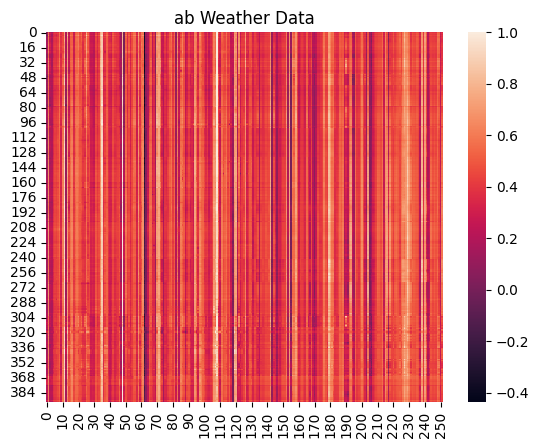

<Figure size 640x480 with 0 Axes>

Training Data Length:  394 X 201
Test Data Length:  394 X 51
Testing percentage:  20.238095238095237 %
Total data size:  394 X 252


Train data size(batch, row, column) Train X:  (166, 394, 12)  ,Train Y:  (166, 394, 1)
test data size(batch, row, column) Test X:  (16, 394, 12)  ,Test Y:  (16, 394, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 394, 64)          11520     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 394, 1)            65        
                                                                 
Total params: 11,585
Trainable params: 11,585
Non-trainable params: 0
_________________________________________________________________
Total compile time: -------- 324.26986145973206 s
1/1 [==============================] - 1s 594ms/step
394 394


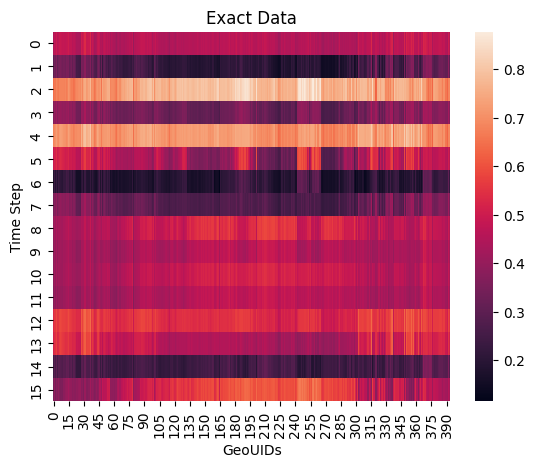

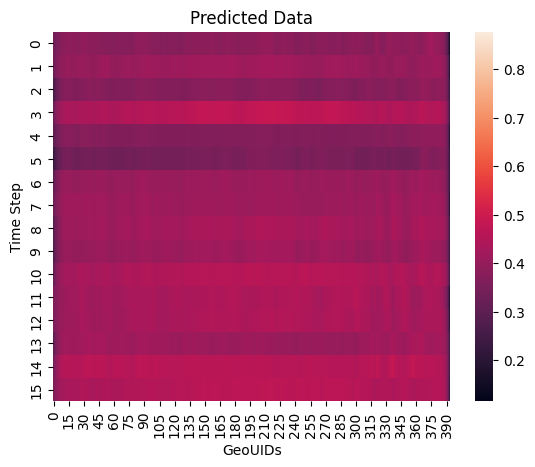

error shape:  (16, 394)


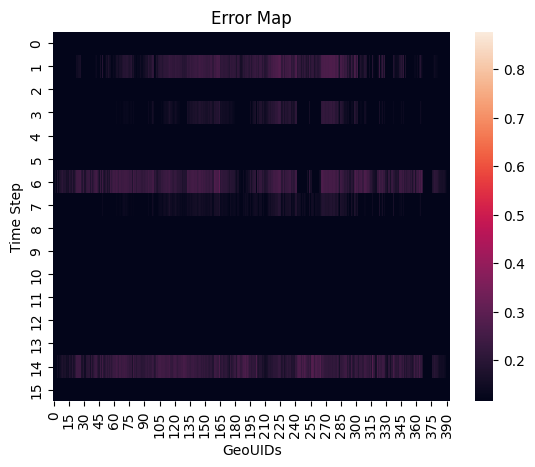

predict data size:  394 16
exact data size:  394 16
MAE:  0.2121039447971376 STD:  0.18853550051434795
########################End##################################


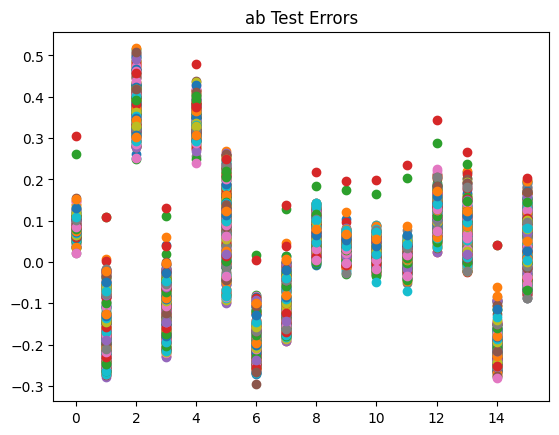

In [ ]:
# my version
p1, p2 = 0.8, 1
train_months = 12 #use the previous month to predict the next 2 months
predict_position = 24
predict_month = 1
ab_py, ab_ty, ab_error,ab_sd, ab_model = SP_Learner1(ab_list,train_months ,predict_month,predict_position-1,1,p1,p2,'ab')

In [ ]:
# Post Modelling
# i really should tune this thing smh

print('Total MAE', np.mean(ab_error), 'Total STD: ', np.mean(ab_sd))

Total MAE 0.2121039447971376 Total STD:  0.18853550051434795


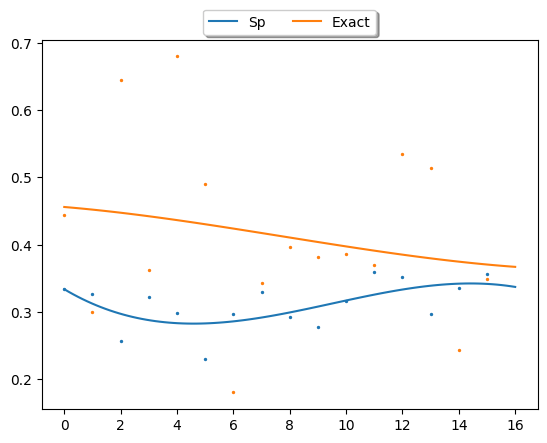

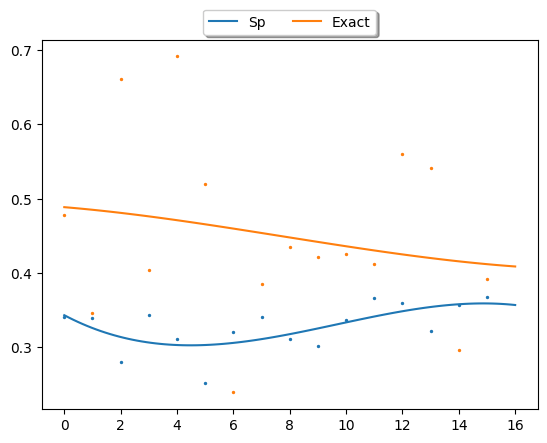

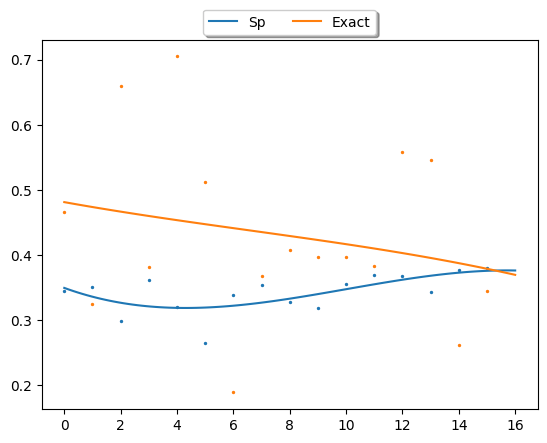

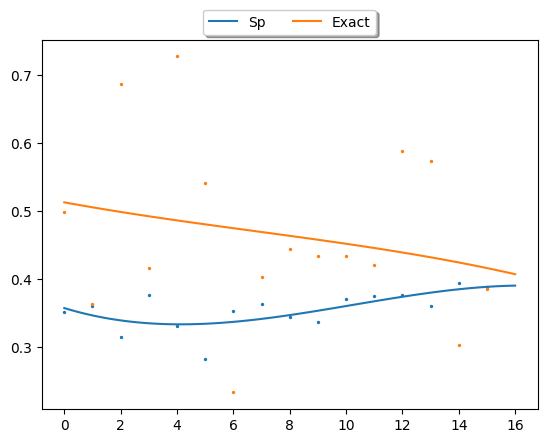

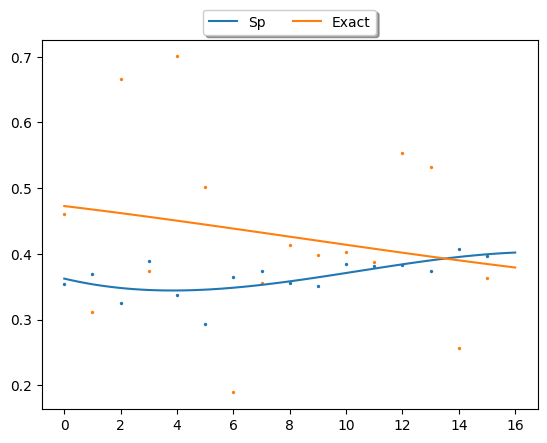

In [ ]:
# plot things (sample of them)

for i in range(5):
    py_ty_plot(ab_py, ab_ty,2,100, 'Alberta_Weather_plot',i)

########################Start##################################


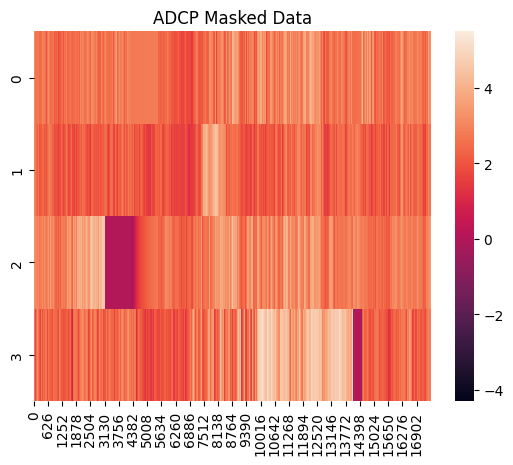

<Figure size 640x480 with 0 Axes>

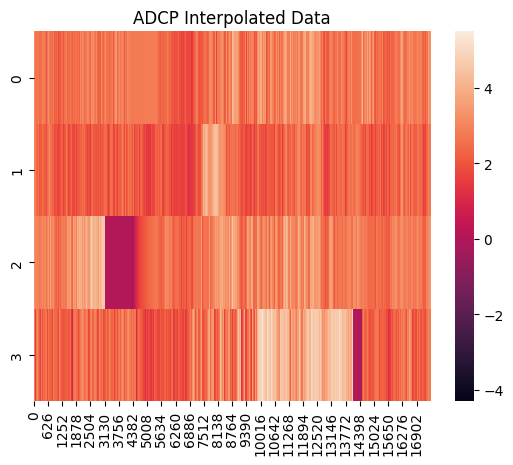

<Figure size 640x480 with 0 Axes>

Training Data Length:  4 X 14016
Test Data Length:  4 X 3504
Testing percentage:  20.0 %
Total data size:  4 X 17520


Train data size(batch, row, column) Train X:  (13963, 4, 6)  ,Train Y:  (13963, 4, 1)
test data size(batch, row, column) Test X:  (3451, 4, 6)  ,Test Y:  (3451, 4, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 4, 6)              0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 64)            9984      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4, 1)              65        
                                                                 
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________
Total compile time: -------- 1104.4903156757355 s
108/108 [======================

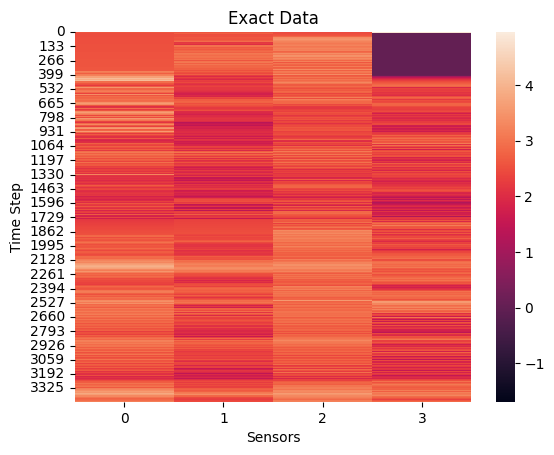

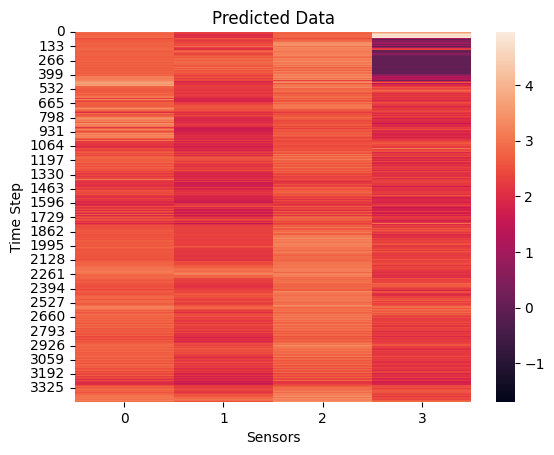

error shape:  (3451, 4)


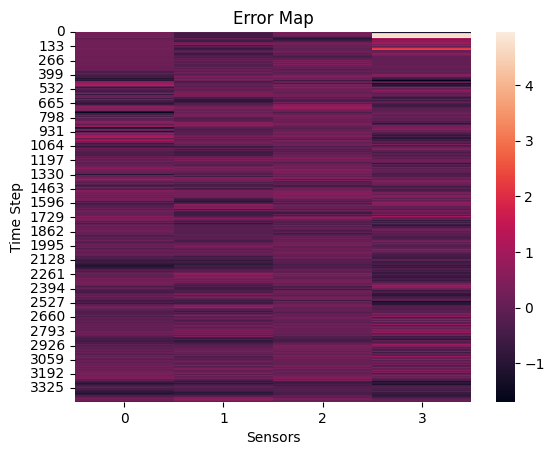

predict data size:  4 3451
exact data size:  4 3451
Predicted Data Point size for sensor 1  3451
Predicted Data Point size for sensor 2  3451
Predicted Data Point size for sensor 3  3451
Predicted Data Point size for sensor 4  3451
MAE:  4.352044225494988 STD:  6.683416188361059
########################End##################################


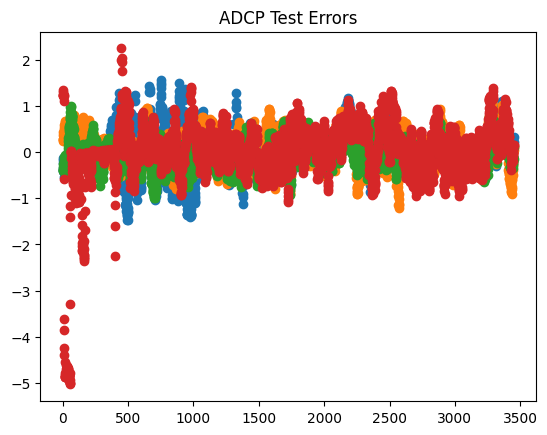

In [ ]:
p1, p2 = .8, 1
train_hour = 3
predict_hour = 1
predict_position = 24
adcp_py, adcp_ty, adcp_error,adcp_sd, adcp_model = SP_Learner(adcp,train_hour*2 ,predict_hour,predict_position*2-1,1,p1,p2,'ADCP')

In [ ]:
# Sensor MAEs and STDs:
for i in range(len(adcp)):
    print('MAE for sensor'+str(i+1)+' ', adcp_error[i], ' STD: ', adcp_sd[i])
print('Total MAE', np.mean(adcp_error), 'Total STD: ', np.mean(adcp_sd))

MAE for sensor1  5.228783588011978  STD:  6.52376578677657
MAE for sensor2  3.2061228611579033  STD:  2.847332560617144
MAE for sensor3  3.6535357412388403  STD:  3.073096087581173
MAE for sensor4  5.319734711571231  STD:  14.28947031846935
Total MAE 4.352044225494988 Total STD:  6.683416188361059


#### Check the predicted data and exact data

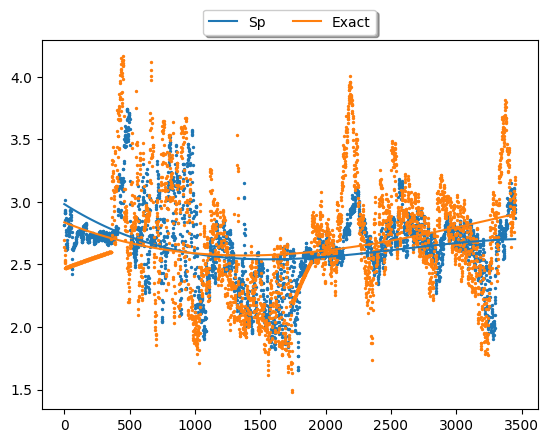

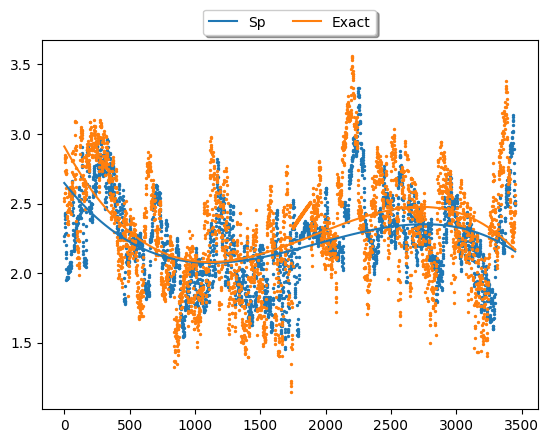

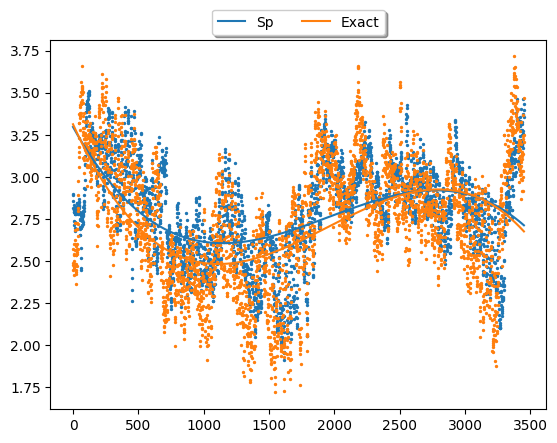

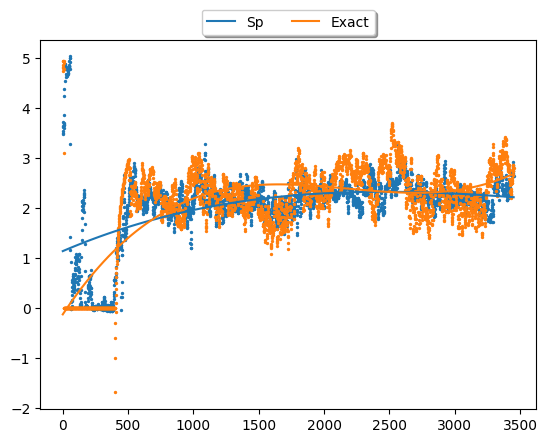

In [ ]:
for i in range(len(adcp)):
    py_ty_plot(adcp_py, adcp_ty,2,100, 'ADCP_sensor_plot',i)